# Poisson equation over L-shaped domain - TensorFlow v1 backend

*Last edited: 2023-07-18*

Source: https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.Lshape.html

Poisson equation:

$ - u_{xx}-u_{yy} = 1, \qquad  \Omega = [-1,1]^2 \backslash [0,1]^2 $

and Dirichlet boundary conditions:

$ u(x,y)=0, \qquad (x,y)\in \partial \Omega $

where:
- Ω is the function domain
- ∂Ω is the boundary of the domain

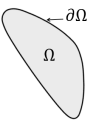
Source: simscale.com

$[-1,1]^2$ is the unit square, while $[0,1]^2$ is the quarter of square that incluides the corner at the origin.

So $ [-1,1]^2 \backslash [0,1]^2 $ is the other three-fourths of the square, a (roughly) ell-shaped region (or exactly the shape of the [L-tromino](https://en.wikipedia.org/wiki/Tromino)). 

[[Source]]( https://math.stackexchange.com/questions/1498639/notation-what-does-0-12-backslash-0-0-52-mean)

First, the DeepXDE module is imported:

In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

2023-07-18 23:12:27.096523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.




We begin by defining a computational geometry. We can use a built-in class `Polygon` as follows

In [2]:
geom = dde.geometry.Polygon(
    [[0, 0], [1, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]]
)

The geometry in this case is a polygon with six line segments, which is in a L-shape.

Next, we express the PDE residual of the Poisson equation:

In [3]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    f = -dy_xx - dy_yy - 1
    return f

The first argument to `pde` is the network input, i.e., the x-coordinate. The second argument is the network output, i.e., the solution u(x) and we use `y` as the name of the variable.

Next, we consider the Dirichlet boundary condition. A simple Python function, returning a boolean, is used to define the subdomain for the Dirichlet boundary condition. The function should return `True` for those points inside the subdomain and `False` for the points outside. In our case, the points (x,y) of the Dirichlet boundary condition are $ (x,y) \in \partial\{ [-1,1]^2\backslash [0,1]^2 \} $.

In [4]:
def boundary(_, on_boundary):
    return on_boundary

Then, the Dirichlet boundary condition is

In [5]:
bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

Now, we have specified the geometry, PDE residual, and Dirichlet boundary condition. We then define the PDE problem as

In [6]:
data = dde.data.PDE(geom,
                    pde,
                    bc,
                    num_domain=1200,
                    num_boundary=120,
                    num_test=1500)

The number 1200 is the number of training residual points sampled inside the domain, and the number 120 is the number of training points sampled on the boundary. We use 1500 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 5 (i.e., 4 hidden layers) and width 50. Besides, we choose `tanh` as activation function and `Glorot uniform` as initializer :

In [7]:
net = dde.nn.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")

Now, we have the PDE problem and the network. We build a Model and choose the optimizer and learning rate:



In [8]:
model = dde.Model(data, net)

In [9]:
model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.120014 s



/home/x/miniconda3/envs/tf/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-07-18 23:12:43.181247: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-18 23:12:43.181349: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2449 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


'compile' took 1.232519 s



We first train the model for 50000 iterations with Adam optimizer:

In [10]:
model.train(iterations=50000)

2023-07-18 23:12:43.935706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2023-07-18 23:12:44.533425: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1d90018380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-18 23:12:44.533472: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2023-07-18 23:12:44.696572: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-18 23:12:44.856155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-18 23:12:46.981313: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [9.83e-01, 2.42e-02]    [9.78e-01, 2.42e-02]    []  
1000      [1.50e-04, 2.29e-03]    [1.16e-04, 2.29e-03]    []  
2000      [2.96e-04, 1.66e-03]    [2.27e-04, 1.66e-03]    []  
3000      [5.54e-04, 1.04e-03]    [4.48e-04, 1.04e-03]    []  
4000      [2.45e-04, 6.08e-04]    [2.37e-04, 6.08e-04]    []  
5000      [1.63e-04, 4.41e-04]    [1.25e-04, 4.41e-04]    []  
6000      [1.78e-04, 3.13e-04]    [1.44e-04, 3.13e-04]    []  
7000      [7.36e-04, 2.54e-04]    [6.84e-04, 2.54e-04]    []  
8000      [6.95e-05, 1.96e-04]    [5.76e-05, 1.96e-04]    []  
9000      [8.35e-04, 2.28e-04]    [7.73e-04, 2.28e-04]    []  
10000     [1.10e-04, 1.65e-04]    [1.13e-04, 1.65e-04]    []  
11000     [3.11e-05, 1.55e-04]    [2.49e-05, 1.55e-04]    []  
12000     [2.83e-05, 1.50e-04]    [2.28e-05, 1.50e-04]    []  
13000     [3.49e-05, 1.56e-04]    [3.34e-05, 1.56e-04]    []  
14000     [3.19e-04, 1.57e-04]    [3.11e-04, 1.5

(<deepxde.model.LossHistory at 0x7f1e4ff4ef10>,
 <deepxde.model.TrainState at 0x7f1e4ffa8130>)

From [1]: 

We remark that based on our experience, for smooth PDE solutions L-BFGS can find a good solution with less iterations than Adam, because L-BFGS uses second-order derivatives of the loss function, while Adam only relies
on first-order derivatives. However, for stiff solutions L-BFGS is more likely to be stuck at a bad local minimum.

We first use Adam for a certain number of iterations, and then switch to L-BFGS. The optimizer L-BFGS does not require learning rate, and the neural network is trained until convergence, so the number of iterations is also ignored for L-BFGS.

From [2]:

In the training phase, an optimization process targeting the residual minimization determines the weights and biases of the surrogate network. Typically, we use two optimizers in succession: the Adam optimizer as first and then a Broyden-Fletcher-Goldfarb-Shanno (BFGS) optimizer [6]. BFGS uses the Hessian matrix (curvature in highly dimensional space) to calculate the optimization direction and provides more accurate results. However, if used directly without using the Adam optimizer can rapidly converge to a local minimum (for the residual) without exiting. For this reason, the Adam optimizer is used first to avoid local minima, and then the solution is refined by BFGS. We note that the typical BFGS used in PINNs is the L-BFGS-B: L-BFGS is a limited-memory version of BFGS to handle problems with many variables, such as DL problems; the BFGS-B is a variant of BFGS for bound constrained optimization problems. In our work, we tested several optimizers, including Newton and Powell methods, and found that L-BFGS-B provides by far the highest accuracy and faster convergence in all our test problems. L-BFGS-B is currently the most critical technology for PINNs.

And then we **train the model again** using L-BFGS. After we train the network using Adam, we **continue to train** the network using L-BFGS to achieve a smaller loss:

In [11]:
model.compile("L-BFGS")

Compiling model...
'compile' took 0.342651 s



In [12]:
losshistory, train_state = model.train()

2023-07-18 23:15:31.153428: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1780] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


Training model...

Step      Train loss              Test loss               Test metric
50000     [4.35e-05, 5.99e-05]    [3.98e-05, 5.99e-05]    []  
51000     [8.47e-06, 1.92e-05]    [8.47e-06, 1.92e-05]        
52000     [5.10e-06, 9.95e-06]    [5.10e-06, 9.95e-06]        
53000     [3.16e-06, 6.92e-06]    [3.16e-06, 6.92e-06]        
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000008
  Number of iterations: 3499
  Number of functions evaluations: 3626
53626     [2.57e-06, 5.48e-06]    [3.76e-06, 5.48e-06]    []  

Best model at step 53626:
  train loss: 8.05e-06
  test loss: 9.24e-06
  test metric: []

'train' took 53.020176 s



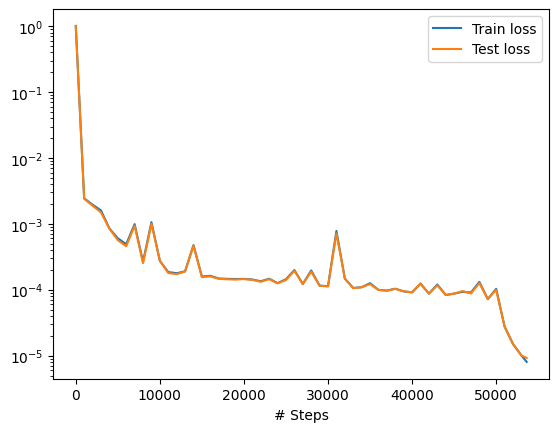

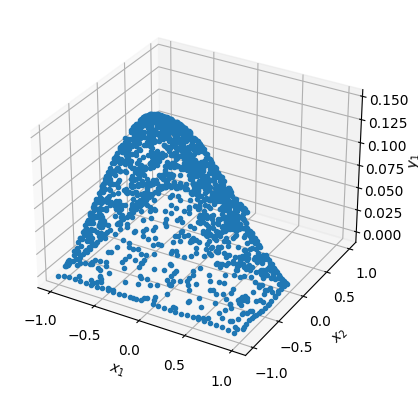

In [13]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

# References

[1] LU LU. DEEPXDE: A DEEP LEARNING LIBRARY FOR SOLVING DIFFERENTIAL EQUATIONS

[2] STEFANO MARKIDIS. The Old and the New: Can Physics-Informed Deep-Learning Replace
Traditional Linear Solvers?
